# EXPERIMENT SETUP #4 - Hyperparameter tuning

Now that we have selected the model, the next step in the pipeline is to tune the hyperparameters such as learning rate and see you get the most out of your model.

## Load Data

In [1]:
!pip install transformers nltk

     |████████████████████████████████| 2.1MB 6.4MB/s 
     |████████████████████████████████| 3.3MB 36.6MB/s 
     |████████████████████████████████| 901kB 46.2MB/s 


In [2]:
import pandas as pd
%matplotlib inline
import numpy as np
import tensorflow as tf
from google.colab import drive
import os
import bert
import trainer
import utils
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import json

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

In [3]:
drive.mount('/gdrive')
os.listdir('/gdrive/MyDrive/data')

Mounted at /gdrive


['test.csv',
 'sample_submission.csv',
 'train.csv',
 'saved_models',
 'training_resultsSimpleBertForSequenceClassification.json',
 'training_resultsModifiedBertForSequenceClassification.json',
 'utils.py',
 'trainer.py',
 'bert.py',
 'training_results_ModifiedBertForSequenceClassification.json',
 'training_results_ModifiedBertForSequenceClassification_1.json',
 'training_results_BertToSingleLayerNeuralNetwork_1.json',
 'training_results_SimpleBertForSequenceClassification_1.json',
 'preprocessing_exp',
 'tokenizer_exp',
 'val.csv',
 'data.csv',
 'hyperparameter_exp',
 'training_exp']

In [4]:
dataset_location = '/gdrive/MyDrive/data'
path = "/gdrive/MyDrive/data/hyperparameter_exp"
use_tpu = True
train = True

In [5]:
if not os.path.exists(path):
    os.mkdir(path)

In [6]:
dataset = pd.read_csv("{}/data.csv".format(dataset_location))
validation_dataset = pd.read_csv("{}/val.csv".format(dataset_location))

In [7]:
dataset.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0
1,21,Deciphering noise amplification and reduction ...,The impact of random fluctuations on the dyn...,0,0,0,0,1,0
2,34,An Unsupervised Homogenization Pipeline for Cl...,Electronic health records (EHR) contain a la...,0,0,0,0,1,0
3,42,Are multi-factor Gaussian term structure model...,"In this paper, we empirically study models f...",0,0,0,0,0,1
4,56,Competing evolutionary paths in growing popula...,Investigating the emergence of a particular ...,0,0,0,0,1,0


In [8]:
dataset["text"] = dataset["TITLE"] + " ." + dataset["ABSTRACT"]
validation_dataset["text"] = validation_dataset["TITLE"] + " ." + validation_dataset["ABSTRACT"]
dataset.head(1)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,text
0,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0,$\mathcal{R}_{0}$ fails to predict the outbrea...


In [9]:
classes = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]

In [10]:
Y = dataset[classes].values
Y_val = validation_dataset[classes].values

In [11]:
if use_tpu:
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        strategy = tf.distribute.get_strategy() # for CPU and single GPU
        print('Number of replicas:', strategy.num_replicas_in_sync)

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.98.185.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.185.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Train
The choice of loss function was made after going through the following articles
* [Understanding categorical entroy](https://gombru.github.io/2018/05/23/cross_entropy_loss/)
* [Multilabel Classification with keras](https://machinelearningmastery.com/multi-label-classification-with-deep-learning/).
* [Stackexchange](https://stats.stackexchange.com/questions/207794/what-loss-function-for-multi-class-multi-label-classification-tasks-in-neural-n) thread.

The idea is that a the output is a binary, ie 0 or 1, for each class as such binary cross entropy would make more sense as the problems is binary classification for each class.

This [stackoverflow](https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification) thread also played an important part in the choices.



In [12]:
class ModelConfig:
    max_length = 200
    bert_name = "bert-base-uncased"
    num_labels = 6
    optimizer = tf.keras.optimizers.Adam(0.00001)
    loss_function = "binary_crossentropy"
    metrics = ["accuracy"]


class TrainerConfig:
    test_size = 0.2
    fold_count = 8
    batch_size = 64
    epochs = 10

#### Learning rate 0.1
Learning rate is a number that effects how much error is adjusted in the neural network during each backpropagation, a high number means the weight adjustment will be significant. This experiment tries to see what a high learning rate can do.

In [ ]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
version = "0.1"
ModelConfig.optimizer = tf.keras.optimizers.Adam(0.1)
if use_tpu:
    with strategy.scope():
        model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
        model.version = version
        model.build(processors=processors)
else:
    model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
    model.version = version
    model.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history = trainer_methodology.train()
    training_history = utils.training_history_to_dict(training_history)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        json.dump(training_history, file)
    model.save(path)
else:
    model.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        training_history = json.load(file)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 1.1613 - accuracy: 0.3114WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 166s 364ms/step - loss: 1.1593 - accuracy: 0.3115 - val_loss: 0.4805 - val_accuracy: 0.4033
Epoch 2/10
250/250 [==============================] - 35s 140ms/step - loss: 0.4569 - accuracy: 0.3375 - val_loss: 0.4663 - val_accuracy: 0.2103
Epoch 3/10
250/250 [==============================] - 35s 139ms/step - loss: 0.4557 - accuracy: 0.3340 - val_loss: 0.4510 - val_accuracy: 0.4033
Epoch 4/10
250/250 [==============================] - 35s 138ms/step - loss: 0.4502 - accuracy: 0.3599 - val_loss: 0.4470 - val_accuracy: 0.4033
Epoch 5/10
250/250 [==============================] - 35s 139ms/step - loss: 0.4497 - accuracy: 0.3600 - val_loss: 0.4519 - val_accuracy: 0.2621
Epoch 6/10
250/250 [==============================] - 35s 139ms/step - loss: 0.4449 - accuracy: 0.3695 - val_loss: 0.4846 - val_accuracy: 0.4033
Epoch 7/10
250/250 [==============================] - 35s 139ms/step - loss: 0.4506 - accuracy: 0.3391 - val_loss: 0.4554 - val_accuracy: 0.

#### Learning rate 0.001
It is quite evident from the previous experiment a high learning rate may not be always good, the analogy I read is that of a driver trying to turn. A high learning rate may end up in overshooting and taking a 80 degree turn for a 40 degree turn. If the learning rate is too low the you might end up taking a 10 degree turn for the same 40 degree turn. So its important to find a midpoint to avoid overshooting and undershooting. With that in mind we lower th learning rate again

In [ ]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
version = "0.001"
ModelConfig.optimizer = tf.keras.optimizers.Adam(0.001)
if use_tpu:
    with strategy.scope():
        model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
        model.version = version
        model.build(processors=processors)
else:
    model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
    model.version = version
    model.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history = trainer_methodology.train()
    training_history = utils.training_history_to_dict(training_history)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        json.dump(training_history, file)
    model.save(path)
else:
    model.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        training_history = json.load(file)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 0.5005 - accuracy: 0.3319WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 168s 362ms/step - loss: 0.5003 - accuracy: 0.3320 - val_loss: 0.4496 - val_accuracy: 0.4033
Epoch 2/10
250/250 [==============================] - 35s 138ms/step - loss: 0.4443 - accuracy: 0.3871 - val_loss: 0.4427 - val_accuracy: 0.4033
Epoch 3/10
250/250 [==============================] - 34s 138ms/step - loss: 0.4415 - accuracy: 0.3808 - val_loss: 0.4455 - val_accuracy: 0.4033
Epoch 4/10
250/250 [==============================] - 35s 139ms/step - loss: 0.4403 - accuracy: 0.3979 - val_loss: 0.4404 - val_accuracy: 0.4033
Epoch 5/10
250/250 [==============================] - 34s 138ms/step - loss: 0.4389 - accuracy: 0.3925 - val_loss: 0.4402 - val_accuracy: 0.4033
Epoch 6/10
250/250 [==============================] - 35s 139ms/step - loss: 0.4381 - accuracy: 0.4048 - val_loss: 0.4391 - val_accuracy: 0.4033
Epoch 7/10
250/250 [==============================] - 35s 139ms/step - loss: 0.4374 - accuracy: 0.3990 - val_loss: 0.4404 - val_accuracy: 0.

#### Learning rate 0.00001

The model is still struggling to find a fit. We again lower the learning rate a bit more to see what can be done.

In [ ]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
version = "0.00001"
ModelConfig.optimizer = tf.keras.optimizers.Adam(0.00001)
if use_tpu:
    with strategy.scope():
        model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
        model.version = version
        model.build(processors=processors)
else:
    model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
    model.version = version
    model.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history = trainer_methodology.train()
    training_history = utils.training_history_to_dict(training_history)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        json.dump(training_history, file)
    model.save(path)
else:
    model.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        training_history = json.load(file)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 0.2979 - accuracy: 0.6671WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 169s 366ms/step - loss: 0.2977 - accuracy: 0.6674 - val_loss: 0.1840 - val_accuracy: 0.7026
Epoch 2/10
250/250 [==============================] - 35s 139ms/step - loss: 0.1682 - accuracy: 0.7789 - val_loss: 0.1675 - val_accuracy: 0.7412
Epoch 3/10
250/250 [==============================] - 35s 138ms/step - loss: 0.1468 - accuracy: 0.7979 - val_loss: 0.1667 - val_accuracy: 0.7479
Epoch 4/10
250/250 [==============================] - 35s 139ms/step - loss: 0.1324 - accuracy: 0.7967 - val_loss: 0.1679 - val_accuracy: 0.7299
Epoch 5/10
250/250 [==============================] - 35s 138ms/step - loss: 0.1129 - accuracy: 0.8165 - val_loss: 0.1748 - val_accuracy: 0.7384
Epoch 6/10
250/250 [==============================] - 35s 138ms/step - loss: 0.0974 - accuracy: 0.8316 - val_loss: 0.1853 - val_accuracy: 0.7384
Epoch 7/10
250/250 [==============================] - 35s 138ms/step - loss: 0.0801 - accuracy: 0.8423 - val_loss: 0.1967 - val_accuracy: 0.

#### Learning rate 0.01 with decay 0.01
This experiment looks a lot better. It might be worth trying out a few more values, but due to lack of time and resource we have to settle with this number.

Another idea is that we start with a very high learning rate as the error might be high in the begining and then reduce the learning rate every epoch, to make that happen a decay value needs to be set. Its important to test out more than one set of values for learning rate and decay. Again due to the lack of time and compute, we are settling with one setup and seeing what effect decay has.

In [ ]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
version = "0.01_with_decay_0.01"
ModelConfig.optimizer = tf.keras.optimizers.Adam(lr=0.01, decay=0.01)
if use_tpu:
    with strategy.scope():
        model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
        model.version = version
        model.build(processors=processors)
else:
    model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
    model.version = version
    model.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history = trainer_methodology.train()
    training_history = utils.training_history_to_dict(training_history)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        json.dump(training_history, file)
    model.save(path)
else:
    model.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        training_history = json.load(file)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.3120WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 176s 365ms/step - loss: 0.6436 - accuracy: 0.3122 - val_loss: 0.4415 - val_accuracy: 0.4033
Epoch 2/10
250/250 [==============================] - 35s 139ms/step - loss: 0.4407 - accuracy: 0.3914 - val_loss: 0.4423 - val_accuracy: 0.4033
Epoch 3/10
250/250 [==============================] - 35s 140ms/step - loss: 0.4410 - accuracy: 0.4018 - val_loss: 0.4408 - val_accuracy: 0.4033
Epoch 4/10
250/250 [==============================] - 35s 140ms/step - loss: 0.4392 - accuracy: 0.3927 - val_loss: 0.4411 - val_accuracy: 0.4033
Epoch 5/10
250/250 [==============================] - 35s 140ms/step - loss: 0.4375 - accuracy: 0.4039 - val_loss: 0.4397 - val_accuracy: 0.4033
Epoch 6/10
250/250 [==============================] - 35s 140ms/step - loss: 0.4362 - accuracy: 0.4098 - val_loss: 0.4406 - val_accuracy: 0.4033
Epoch 7/10
250/250 [==============================] - 35s 141ms/step - loss: 0.4362 - accuracy: 0.4106 - val_loss: 0.4392 - val_accuracy: 0.

#### SGD as optimizer
This experiment seems very similar to the experiment with learning rate 0.001. Changing the initial value of learning rate to a lower number or changing the value of decay to a higher number might be worth looking into, but then again for now we are settling with these numbers.

From [this](https://ruder.io/optimizing-gradient-descent/) article, we learnt about a few otimizing techniques and since we couldnt test out every optimizer we selected Adam and SGD, 2 of the most popular optimizers and testing out what each can acheive. We have selected the best learning rate Adam has performed on to keep SGD the only variable.

In [ ]:
processors = [utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence]
version = "SGD"
ModelConfig.optimizer = tf.keras.optimizers.SGD(0.00001)
if use_tpu:
    with strategy.scope():
        model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
        model.version = version
        model.build(processors=processors)
else:
    model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
    model.version = version
    model.build(processors=processors)
if train:
    trainer_methodology = trainer.TestTrainSplitTrainer(config=TrainerConfig, model=model)
    trainer_methodology.initialize(x=dataset["text"], y=Y)
    training_history = trainer_methodology.train()
    training_history = utils.training_history_to_dict(training_history)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        json.dump(training_history, file)
    model.save(path)
else:
    model.load(path)
    with open(os.path.join(path, "training_results_{}.json".format(model.name())), "w") as file:
        training_history = json.load(file)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


250/250 [==============================] - ETA: 0s - loss: 0.8064 - accuracy: 0.1881WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).


250/250 [==============================] - 104s 251ms/step - loss: 0.8063 - accuracy: 0.1882 - val_loss: 0.7492 - val_accuracy: 0.2268
Epoch 2/10
250/250 [==============================] - 30s 119ms/step - loss: 0.7347 - accuracy: 0.2141 - val_loss: 0.6812 - val_accuracy: 0.2478
Epoch 3/10
250/250 [==============================] - 30s 119ms/step - loss: 0.6735 - accuracy: 0.2495 - val_loss: 0.6263 - val_accuracy: 0.2698
Epoch 4/10
250/250 [==============================] - 30s 119ms/step - loss: 0.6246 - accuracy: 0.2827 - val_loss: 0.5817 - val_accuracy: 0.3006
Epoch 5/10
250/250 [==============================] - 30s 119ms/step - loss: 0.5850 - accuracy: 0.2960 - val_loss: 0.5467 - val_accuracy: 0.3284
Epoch 6/10
250/250 [==============================] - 30s 120ms/step - loss: 0.5534 - accuracy: 0.3308 - val_loss: 0.5204 - val_accuracy: 0.3554
Epoch 7/10
250/250 [==============================] - 30s 120ms/step - loss: 0.5301 - accuracy: 0.3344 - val_loss: 0.5004 - val_accuracy: 0.

It looks like SGD would need a lot more tweaking to help our model fit better, given more time it would be worthwhile to adjust learning rate and work with decay and see what can be done, as SGD this experiment seems to not overfit. We can see a smooth curve for both accuracy and loss for both train and testing data in the graphs below.

## Evaluate

In [13]:
exp_names = ["0.1 LR", "0.001 LR", "0.00004 LR", "0.01 LR with 0.1 decay", "SGD Optimizer with 0.00001"]

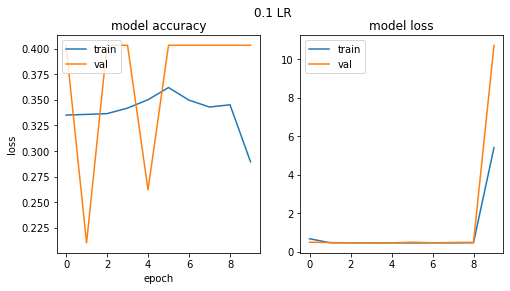

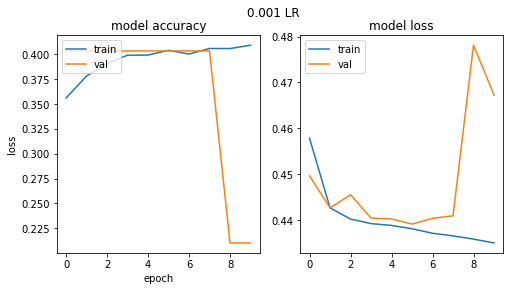

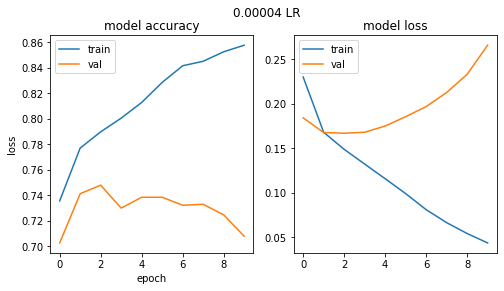

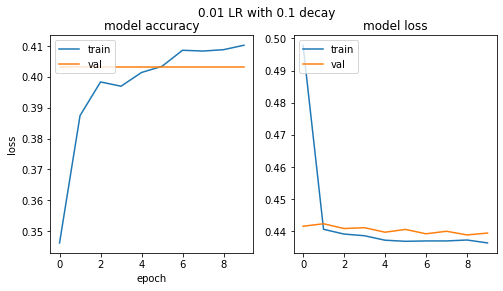

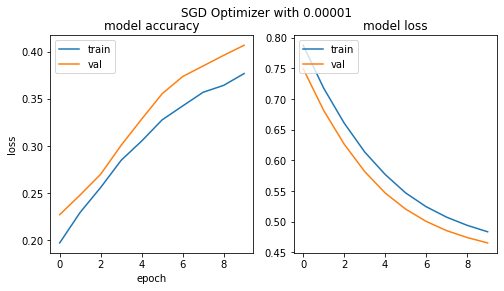

In [15]:
model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
model.version = "0.1"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, exp_names[0])


model.version = "0.001"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, exp_names[1])


model.version = "0.00001"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, exp_names[2])

model.version = "0.01_with_decay_0.01"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, exp_names[3])


model.version = "SGD"
with open(os.path.join(path, "training_results_{}.json".format(model.name())), "r") as file:
    training_history = json.load(file)
utils.plot_training_result(training_history, exp_names[4])

In [16]:
model = bert.BertToSingleLayerNeuralNetwork(config=ModelConfig)
model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence])
model.version = "0.1"
model.load(path)
lr_01_y_pred = model.predict(validation_dataset["text"])


model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence])
model.version = "0.001"
model.load(path)
lr_001_y_pred = model.predict(validation_dataset["text"])


model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence])
model.version = "0.00001"
model.load(path)
lr_00001_y_pred = model.predict(validation_dataset["text"])


model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence])
model.version = "0.01_with_decay_0.01"
model.load(path)
lrd_y_pred = model.predict(validation_dataset["text"])


model.build(processors=[utils.replace_latex_math_with, utils.to_corpus, utils.lemmatize_sentence])
model.version = "SGD"
model.load(path)
sgd_y_pred = model.predict(validation_dataset["text"])

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [17]:
y_preds=[lr_01_y_pred, lr_001_y_pred, lr_00001_y_pred, lrd_y_pred, sgd_y_pred]
Ys=[Y_val, Y_val, Y_val, Y_val, Y_val]
classes=classes
threshold=0.5
model_names=exp_names

In [18]:
utils.print_f1_scores(y_preds, Ys, classes, threshold, model_names)

F1-Score for is  0.1 LR : [('Computer Science', 0.0), ('Physics', 0.0), ('Mathematics', 0.0), ('Statistics', 0.0), ('Quantitative Biology', 0.0), ('Quantitative Finance', 0.0)]
F1-Score for is  0.001 LR : [('Computer Science', 0.0), ('Physics', 0.0), ('Mathematics', 0.0), ('Statistics', 0.0), ('Quantitative Biology', 0.0), ('Quantitative Finance', 0.0)]
F1-Score for is  0.00004 LR : [('Computer Science', 0.7912568306010929), ('Physics', 0.8617363344051447), ('Mathematics', 0.8106194690265487), ('Statistics', 0.8111888111888111), ('Quantitative Biology', 0.9243243243243243), ('Quantitative Finance', 0.9431578947368421)]
F1-Score for is  0.01 LR with 0.1 decay : [('Computer Science', 0.0), ('Physics', 0.0), ('Mathematics', 0.0), ('Statistics', 0.0), ('Quantitative Biology', 0.0), ('Quantitative Finance', 0.0)]
F1-Score for is  SGD Optimizer with 0.00001 : [('Computer Science', 0.26582278481012656), ('Physics', 0.07017543859649122), ('Mathematics', 0.02040816326530612), ('Statistics', 0.0

In [19]:
utils.print_hamming_losses(y_preds, Ys, classes, threshold, model_names)

Hamming for 0.1 LR  :  0.20643627719875662
Hamming for 0.001 LR  :  0.20643627719875662
Hamming for 0.00004 LR  :  0.06006582556226001
Hamming for 0.01 LR with 0.1 decay  :  0.20643627719875662
Hamming for SGD Optimizer with 0.00001  :  0.2213384530992869


Confusion matrix for 0.1 LR


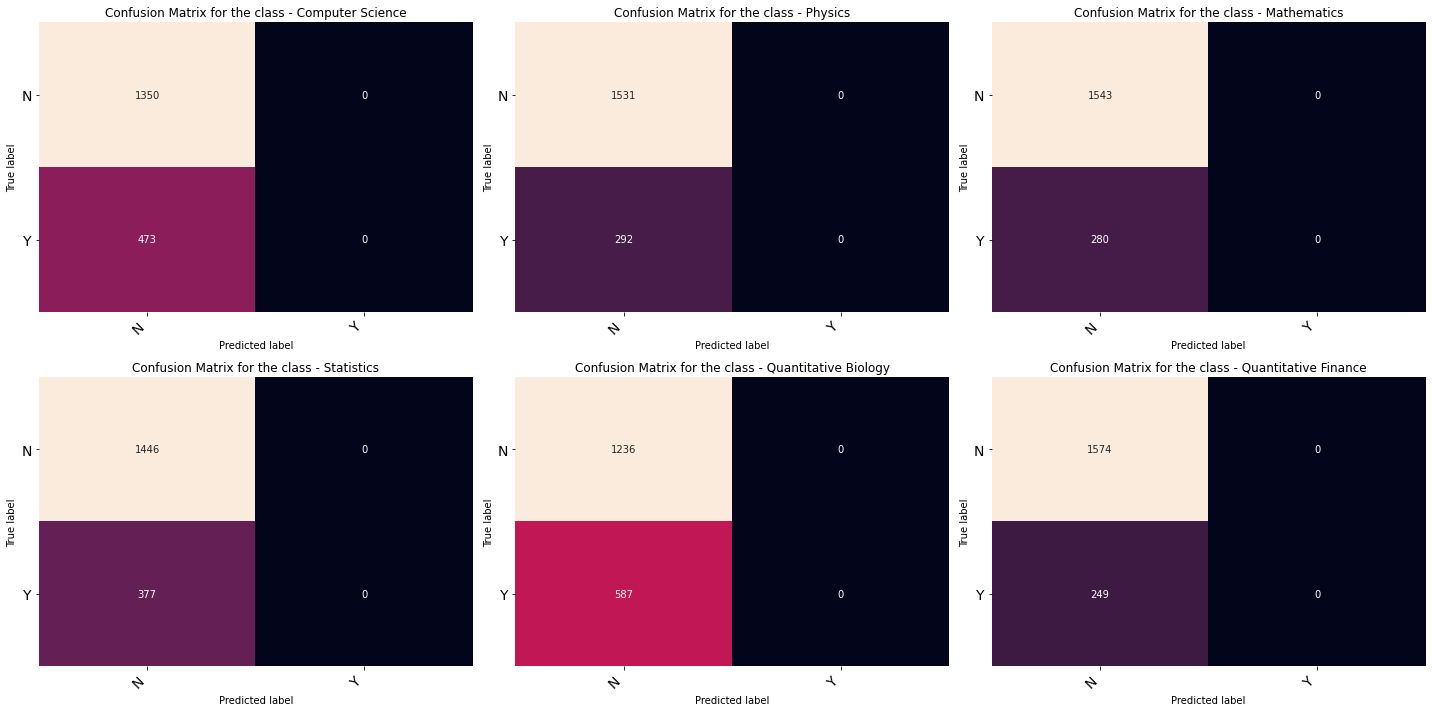

Confusion matrix for 0.001 LR


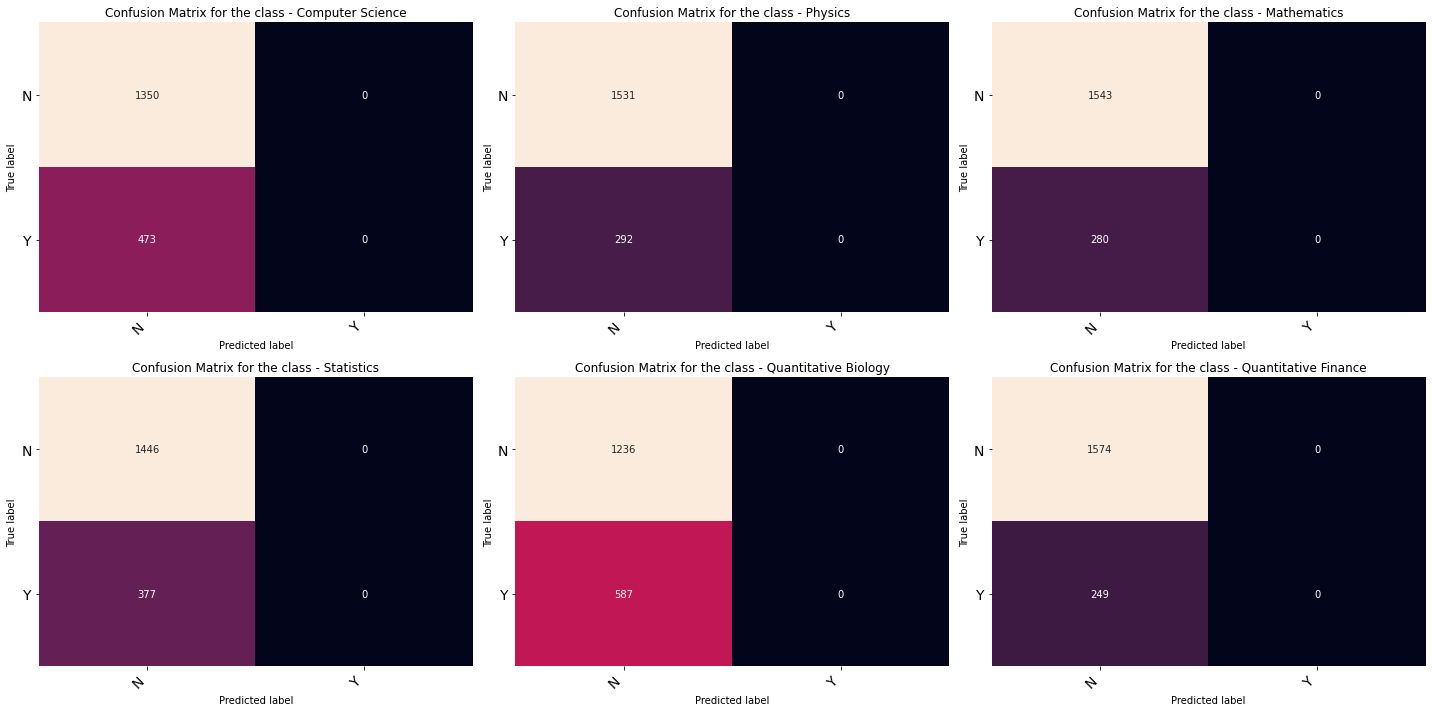

Confusion matrix for 0.00004 LR


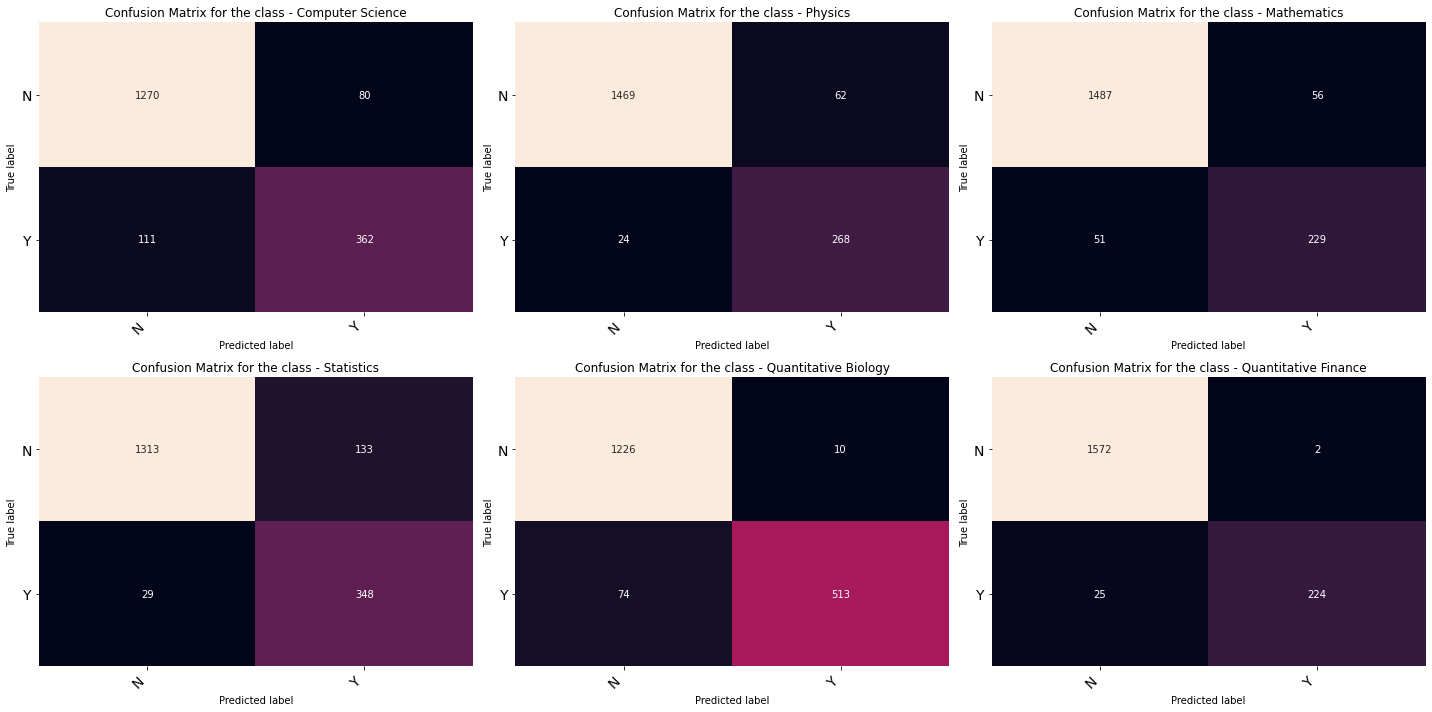

Confusion matrix for 0.01 LR with 0.1 decay


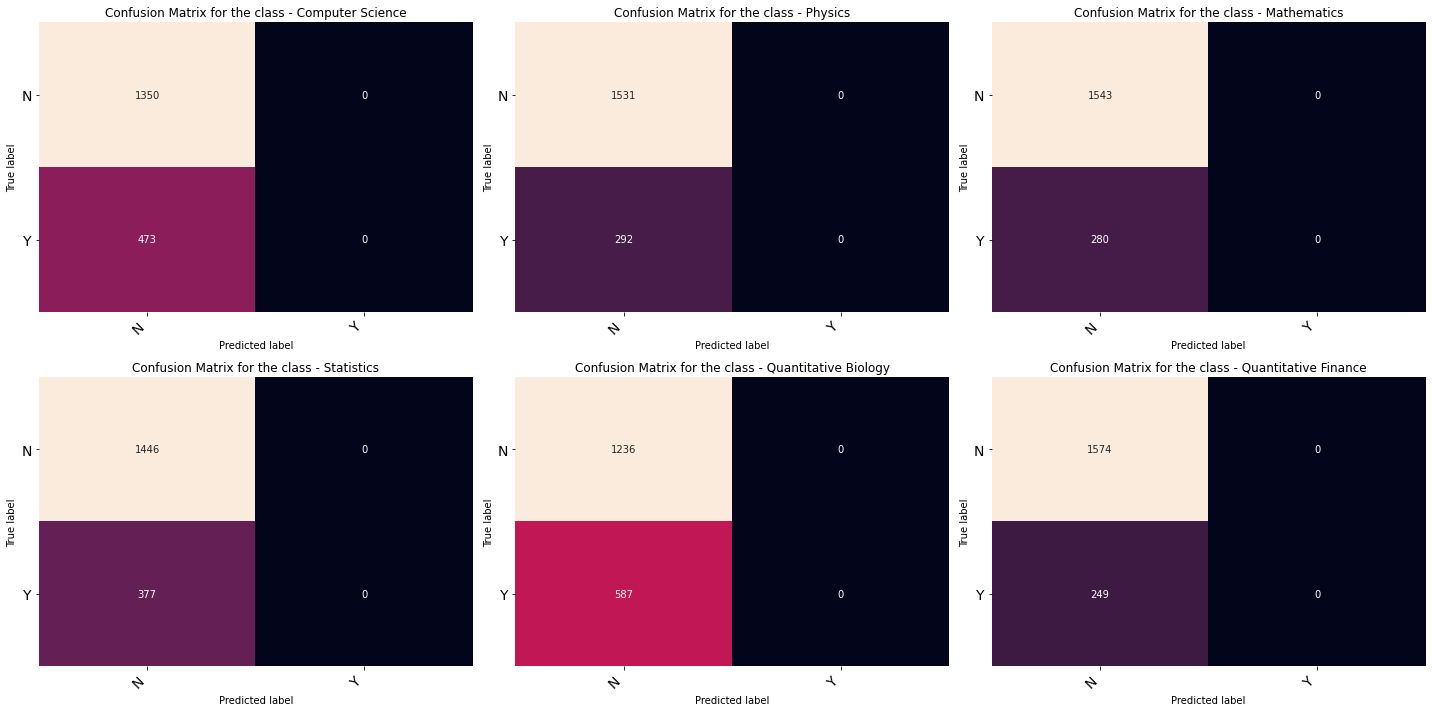

Confusion matrix for SGD Optimizer with 0.00001


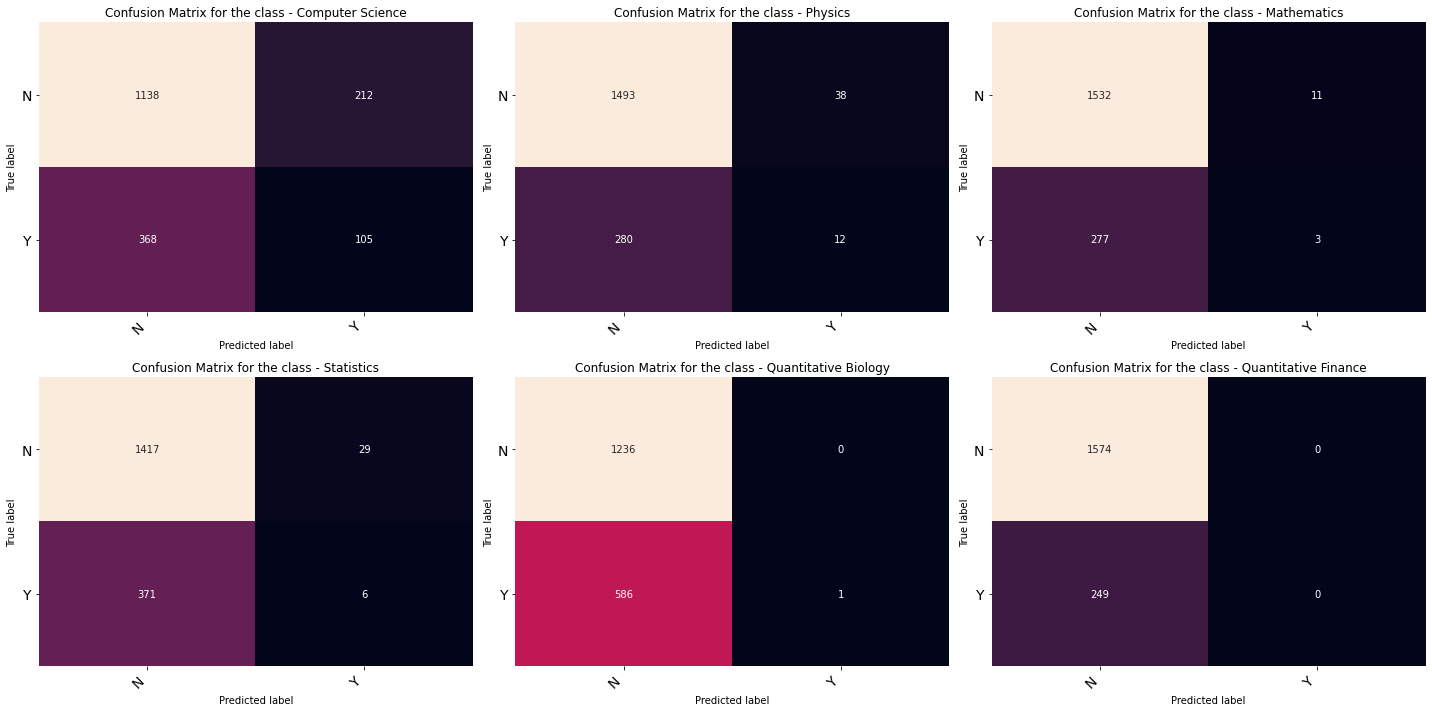

In [20]:
utils.draw_confusion_matrices(y_preds, Ys, classes, threshold, model_names)

ROC curve for 0.1 LR


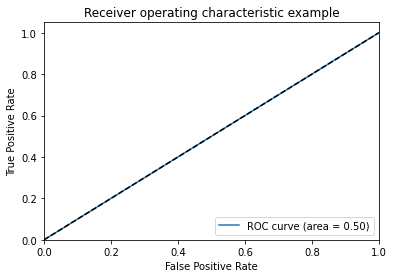

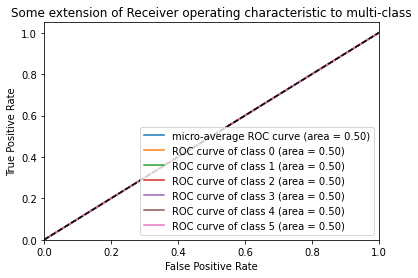

ROC curve for 0.001 LR


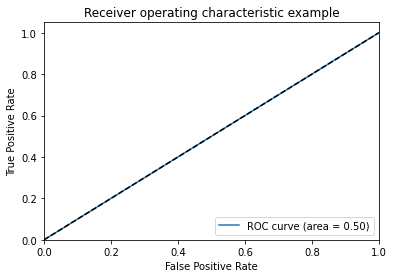

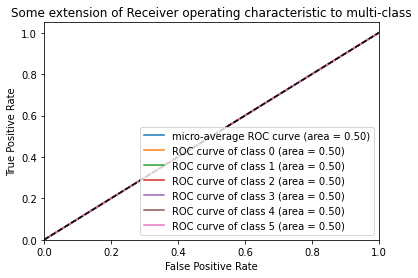

ROC curve for 0.00004 LR


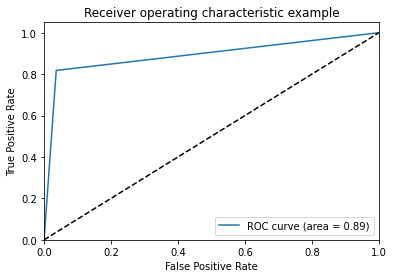

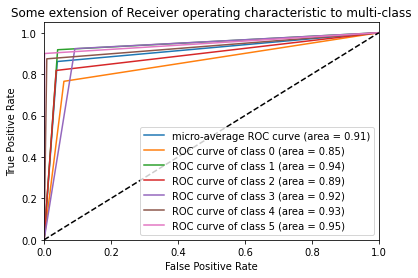

ROC curve for 0.01 LR with 0.1 decay


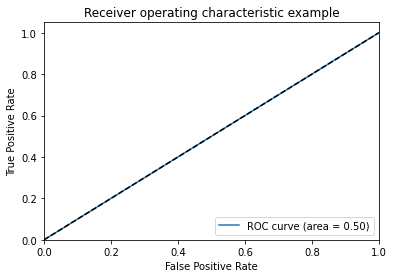

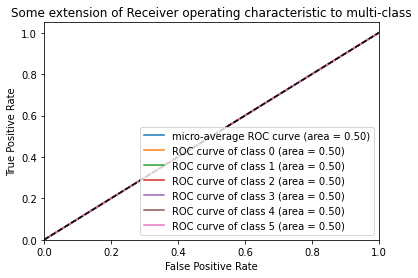

ROC curve for SGD Optimizer with 0.00001


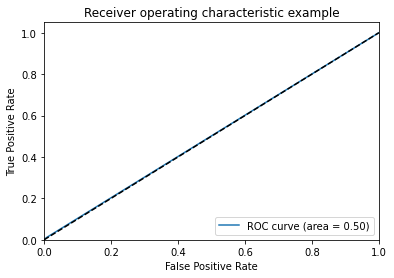

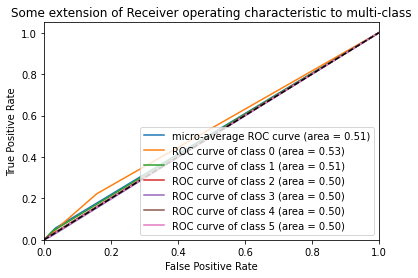

In [21]:
utils.draw_rocs(y_preds, Ys, classes, threshold, model_names)

In [22]:
utils.print_classification_reports(y_preds, Ys, classes, threshold, model_names)

Classification for 0.1 LR  : 
                       precision    recall  f1-score   support

    Computer Science       0.00      0.00      0.00       473
             Physics       0.00      0.00      0.00       292
         Mathematics       0.00      0.00      0.00       280
          Statistics       0.00      0.00      0.00       377
Quantitative Biology       0.00      0.00      0.00       587
Quantitative Finance       0.00      0.00      0.00       249

           micro avg       0.00      0.00      0.00      2258
           macro avg       0.00      0.00      0.00      2258
        weighted avg       0.00      0.00      0.00      2258
         samples avg       0.00      0.00      0.00      2258

Classification for 0.001 LR  : 
                       precision    recall  f1-score   support

    Computer Science       0.00      0.00      0.00       473
             Physics       0.00      0.00      0.00       292
         Mathematics       0.00      0.00      0.00       280
  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusion

Within the bounds of time and compute, four different tests were done with adjusting learning rate and changing the optimizer while keeping the loss function and the model architecture same. Given more time it would have been an interesting experiment to add more layers or change the number of neurons to find the ideal model.


The test results show the Adam optimizer with a learning rate of 0.00001 would give us the best fit.